In [1]:
import os
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from transformers import SegformerForSemanticSegmentation


In [2]:
# Load NVIDIA's Pretrained Model (SegFormer)
nvidia_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

# Extract Encoder and Freeze Weights
nvidia_encoder = nvidia_model.segformer
nvidia_encoder.trainable = False  # Freeze Pretrained Layers


In [3]:
# Define Input Shape (Multispectral Image)
INPUT_SHAPE = (128, 128, 12)
inputs = layers.Input(shape=INPUT_SHAPE)

# Encoder (Placeholder for NVIDIA's SegFormer)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Custom Segmentation Head
x = layers.Conv2DTranspose(128, (3, 3), strides=1, padding="same", activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=1, padding="same", activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

# Build Model
model = Model(inputs, x)

In [4]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.BinaryAccuracy()
    ]
)

# Print Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 256)       │          27,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 128, 128, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 986,881 (3.76 MB)

 Trainable params: 986,881 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Load TIFF images (12-band) and apply min-max normalization
def load_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read().astype(np.float32)  # Shape: (12, 128, 128)
        image = np.transpose(image, (1, 2, 0))  # Convert to (128, 128, 12)

    # Min-max normalization per channel
    min_val = np.min(image, axis=(0, 1), keepdims=True)
    max_val = np.max(image, axis=(0, 1), keepdims=True)

    # Avoid division by zero
    normalized_image = (image - min_val) / (max_val - min_val + 1e-7)
    
    return normalized_image

# Load labels (Binary masks)
def load_label(label_path):
    label = tf.keras.preprocessing.image.load_img(label_path, color_mode="grayscale")
    label = np.array(label, dtype=np.uint8)  # Convert to numpy array
    label = (label > 0).astype(np.int32)  # Ensure binary format
    return label

# Paths to images and labels
data_dir = r"C:\Users\Eman\Downloads\images-20250217T060743Z-001\images"
labels_dir = r"C:\Users\Eman\Downloads\labels-20250217T060744Z-001\labels"

# Get sorted lists of image and label file paths
image_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".tif")])
label_paths = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith(".png")])

# Load data into NumPy arrays
X = np.array([load_image(p) for p in image_paths])
Y = np.array([load_label(p) for p in label_paths])

C:\Users\Eman\anaconda3\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [11]:
# Split Data: 70% Train, 10% Validation, 20% Test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split training + validation into train (70%) and validation (10%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.125, random_state=42)  
# (0.125 * 80% = 10% of total dataset for validation)

# Print dataset sizes
print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (213, 128, 128, 12), Validation Set: (31, 128, 128, 12), Test Set: (62, 128, 128, 12)


In [13]:

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=10,
    verbose=1  # Ensures detailed logs per epoch
)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 256s 18s/step - binary_accuracy: 0.7158 - loss: 0.4929 - mean_io_u: 0.3622 - val_binary_accuracy: 0.8833 - val_loss: 0.3026 - val_mean_io_u: 0.3859
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 133s 9s/step - binary_accuracy: 0.8884 - loss: 0.3059 - mean_io_u: 0.3719 - val_binary_accuracy: 0.8959 - val_loss: 0.2882 - val_mean_io_u: 0.3859
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 125s 9s/step - binary_accuracy: 0.9051 - loss: 0.2797 - mean_io_u: 0.3689 - val_binary_accuracy: 0.9015 - val_loss: 0.2626 - val_mean_io_u: 0.3859
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 126s 9s/step - binary_accuracy: 0.9036 - loss: 0.2713 - mean_io_u: 0.3680 - val_binary_accuracy: 0.8972 - val_loss: 0.2610 - val_mean_io_u: 0.3859
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - binary_accuracy: 0.9002 - loss: 0.2644 - mean_io_u: 0.3681 - val_binary_accuracy: 0.8882 - val_loss: 0.2681 - val_mean_io_u: 0.3859
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - binary_accuracy: 0.90

In [15]:
# Print accuracy & IoU after training
for epoch, (loss, val_loss, iou, val_iou, acc, val_acc) in enumerate(zip(
    history.history["loss"], history.history["val_loss"], 
    history.history["mean_io_u"], history.history["val_mean_io_u"],
    history.history["binary_accuracy"], history.history["val_binary_accuracy"]
)):
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val_Loss={val_loss:.4f}, IoU={iou:.4f}, Val_IoU={val_iou:.4f}, Acc={acc:.4f}, Val_Acc={val_acc:.4f}")

# Save Model
model.save("fine_tuned_nvidia_water_segmentation.h5")


Epoch 1: Loss=0.4114, Val_Loss=0.3026, IoU=0.3628, Val_IoU=0.3859, Acc=0.8114, Val_Acc=0.8833
Epoch 2: Loss=0.3029, Val_Loss=0.2882, IoU=0.3691, Val_IoU=0.3859, Acc=0.8917, Val_Acc=0.8959
Epoch 3: Loss=0.2874, Val_Loss=0.2626, IoU=0.3630, Val_IoU=0.3859, Acc=0.8975, Val_Acc=0.9015
Epoch 4: Loss=0.2756, Val_Loss=0.2610, IoU=0.3627, Val_IoU=0.3859, Acc=0.9004, Val_Acc=0.8972
Epoch 5: Loss=0.2648, Val_Loss=0.2681, IoU=0.3627, Val_IoU=0.3859, Acc=0.9017, Val_Acc=0.8882
Epoch 6: Loss=0.2662, Val_Loss=0.2387, IoU=0.3628, Val_IoU=0.3859, Acc=0.9025, Val_Acc=0.9049
Epoch 7: Loss=0.2712, Val_Loss=0.2380, IoU=0.3627, Val_IoU=0.3859, Acc=0.9024, Val_Acc=0.9045
Epoch 8: Loss=0.2715, Val_Loss=0.2534, IoU=0.3627, Val_IoU=0.3859, Acc=0.9046, Val_Acc=0.9017
Epoch 9: Loss=0.2575, Val_Loss=0.2682, IoU=0.3627, Val_IoU=0.3859, Acc=0.9034, Val_Acc=0.8902
Epoch 10: Loss=0.2572, Val_Loss=0.2600, IoU=0.3630, Val_IoU=0.3859, Acc=0.9040, Val_Acc=0.9094


In [17]:
# Evaluate model on test set
test_loss, test_iou, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

# Print test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - binary_accuracy: 0.9164 - loss: 0.2510 - mean_io_u: 0.3959
Test Loss: 0.2491
Test IoU: 0.3878
Test Accuracy: 0.9163


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


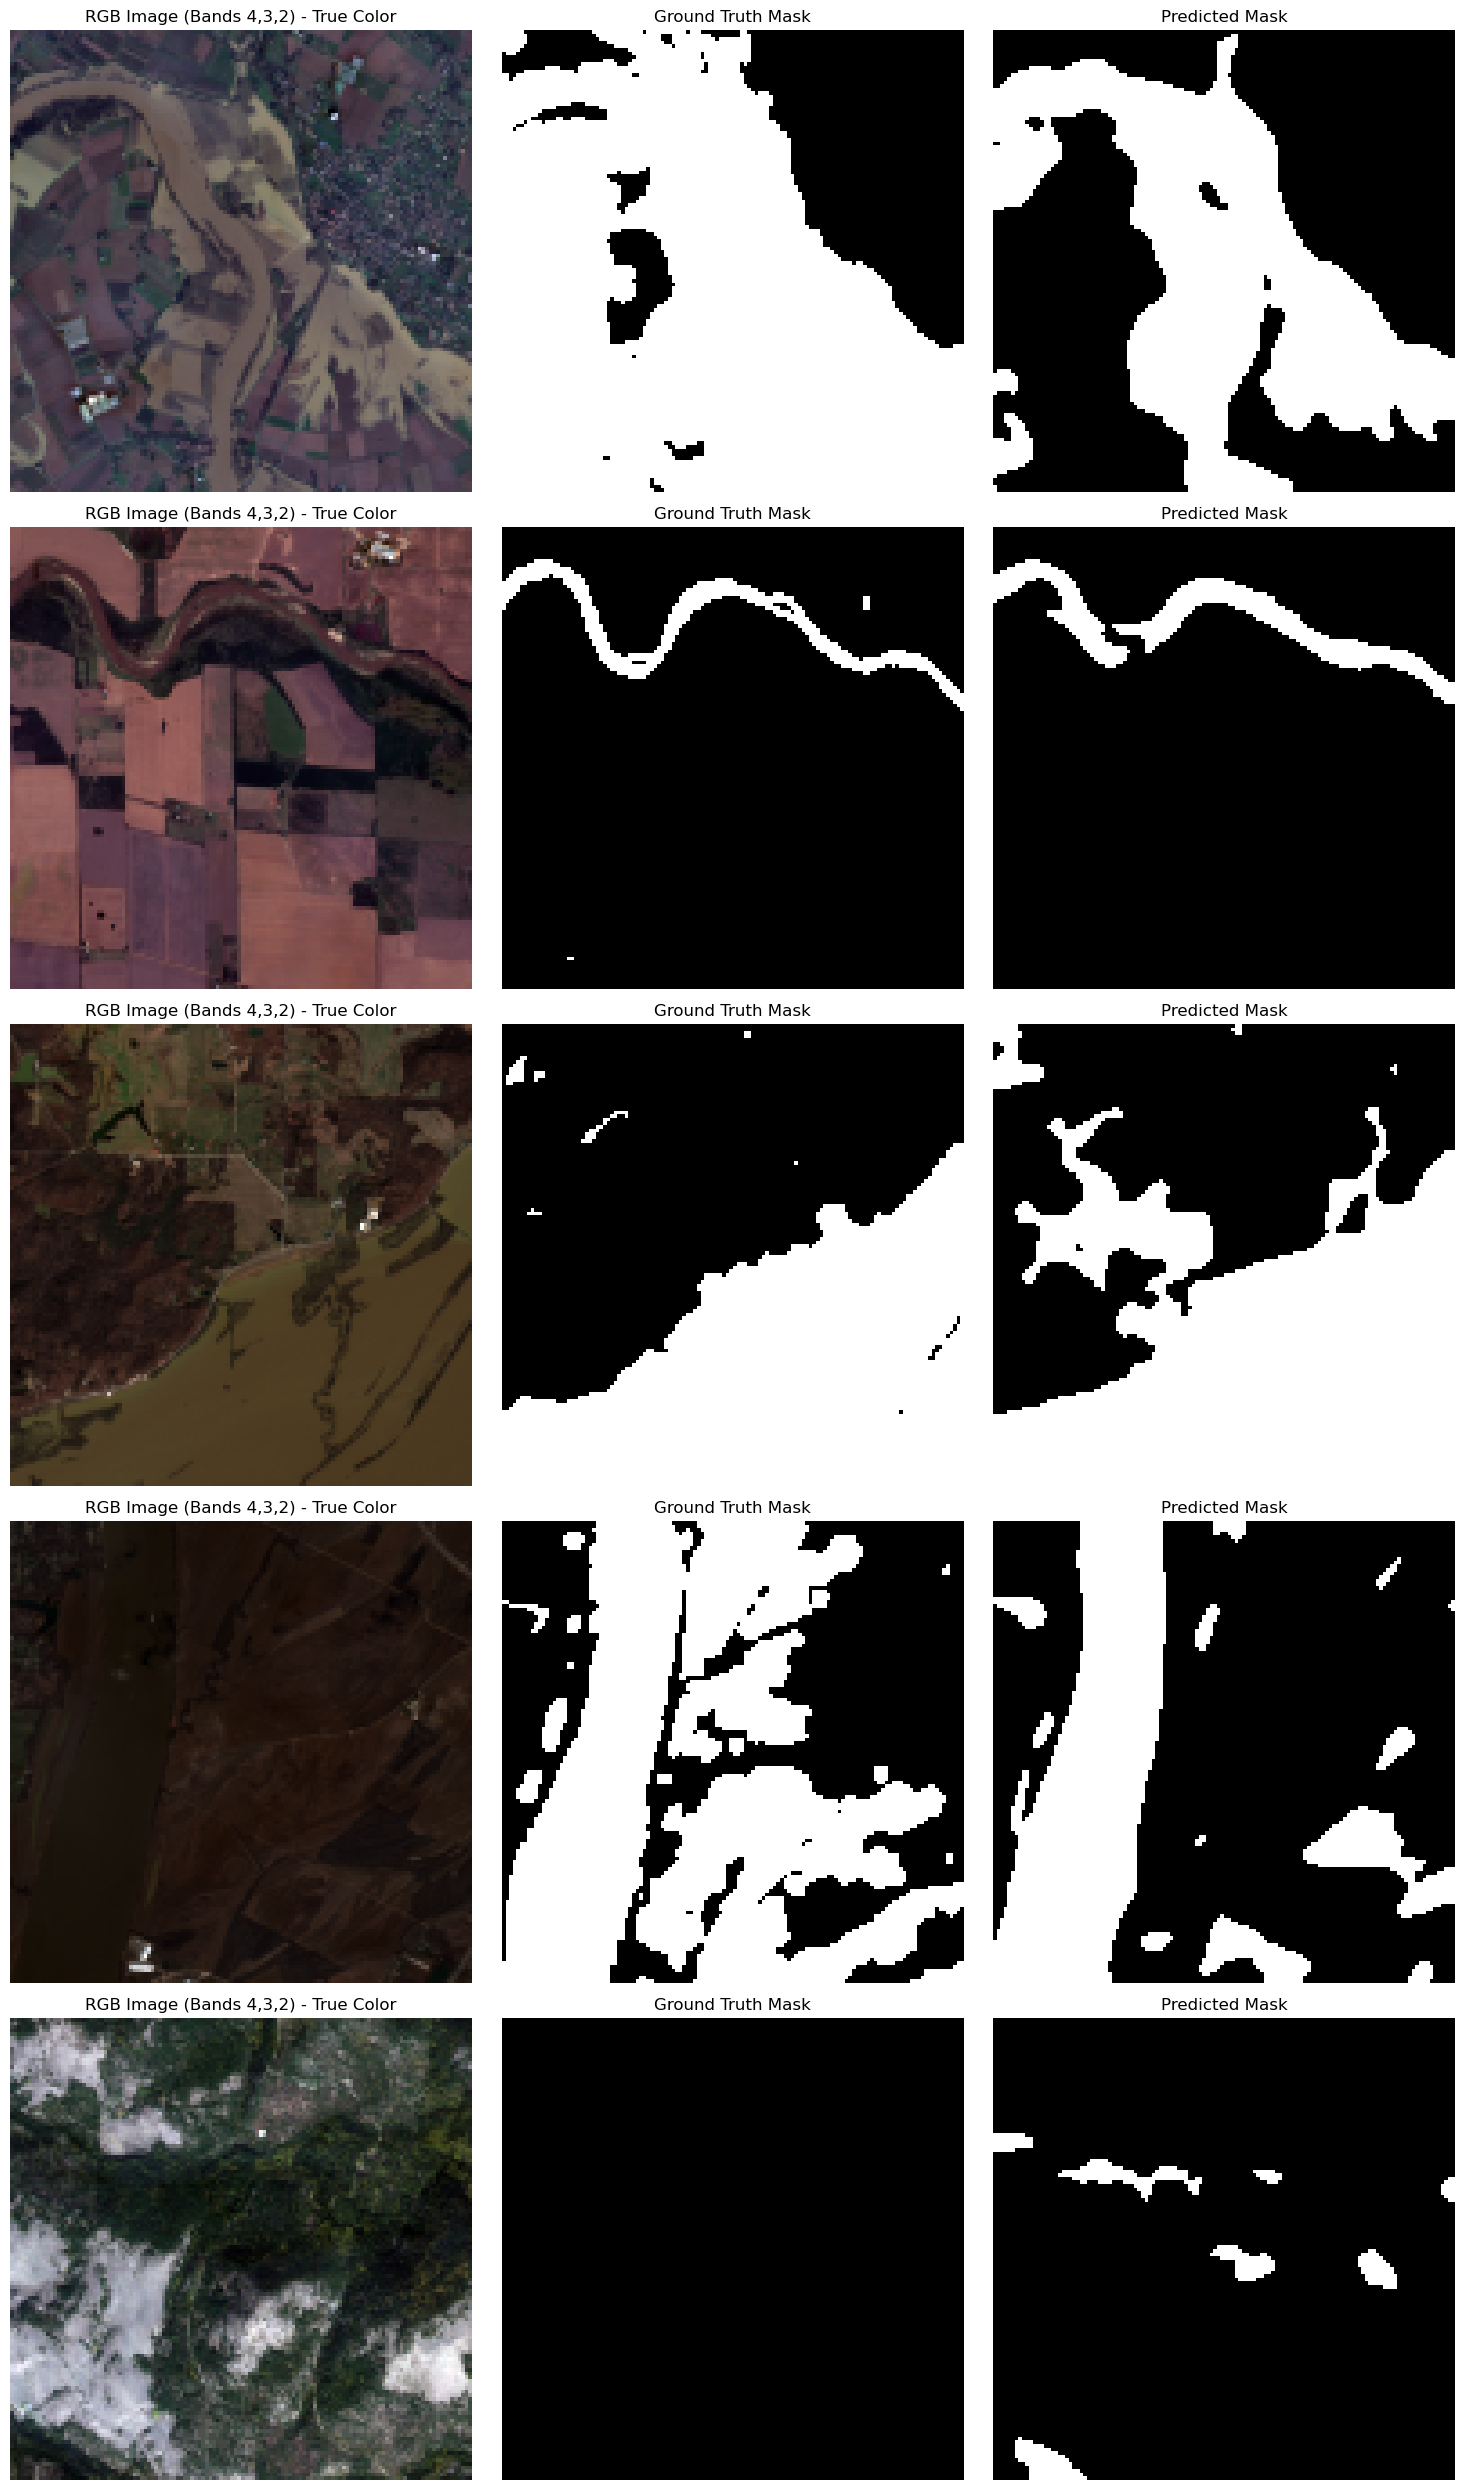

In [31]:
import random

# Function to visualize RGB + ground truth + predictions
def visualize_predictions_rgb(model, X_test, Y_test, num_samples=5, rgb_bands=(4, 3, 2)):  
    """
    Visualizes multispectral images in RGB using the specified bands.

    Parameters:
    - model: Trained segmentation model
    - X_test: Test images (shape: [N, 128, 128, 12])
    - Y_test: Corresponding ground truth masks
    - num_samples: Number of images to display
    - rgb_bands: Tuple (R, G, B) defining the indices of the RGB bands
    """
    plt.figure(figsize=(15, num_samples * 5))
    
    # Select random test indices
    indices = random.sample(range(len(X_test)), num_samples)
    
    for i, idx in enumerate(indices):
        img = X_test[idx]  # Original multispectral image
        true_mask = Y_test[idx]  # Ground truth mask

        # Extract the selected bands for RGB visualization
        rgb_image = img[..., [rgb_bands[0]-1, rgb_bands[1]-1, rgb_bands[2]-1]]  # Adjust for 0-based indexing
        rgb_image = np.clip(rgb_image, 0, 1)  # Normalize for display

        # Model prediction
        pred_mask = model.predict(img[np.newaxis, ...])[0, ..., 0]

        # Binarize prediction (Threshold = 0.5)
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Plot RGB Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(rgb_image)
        plt.title("RGB Image (Bands 4,3,2) - True Color")
        plt.axis("off")

        # Plot Ground Truth Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Plot Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call function with corrected band order (R=4, G=3, B=2)
visualize_predictions_rgb(model, X_test, Y_test, rgb_bands=(4, 3, 2))
